<a href="https://colab.research.google.com/github/vifirsanova/hse-python-course/blob/main/compression/pruning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_dataset

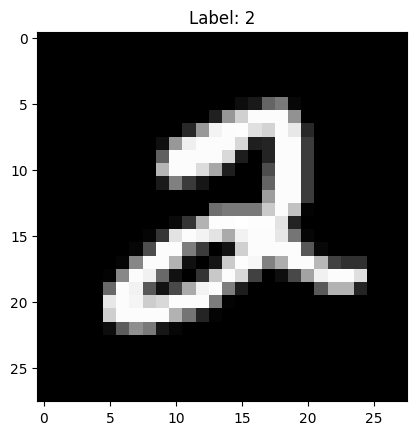

In [5]:
import matplotlib.pyplot as plt

image, label = datasets.MNIST(root='./data')[5]
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [6]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
model.train()
for epoch in range(5):
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

correct / total

0.9876

In [9]:
print("Original conv2 weights shape: ", model.conv2.weight.shape)

Original conv2 weights shape:  torch.Size([32, 16, 3, 3])


In [10]:
import torch.nn.utils.prune as prune

prune.ln_structured(model.conv2, name='weight', amount=0.3, n=1, dim=0)

print("Pruned conv2 weights (structured pruning): ", model.conv2.weight)

Pruned conv2 weights (structured pruning):  tensor([[[[ 0.0174,  0.0186,  0.0910],
          [ 0.0566,  0.0423,  0.1656],
          [-0.0781, -0.0238, -0.0767]],

         [[-0.0153,  0.2052,  0.3743],
          [-0.3707, -0.1565, -0.2173],
          [-0.1477,  0.0346,  0.2144]],

         [[ 0.1312,  0.2666,  0.1396],
          [-0.1686, -0.0973, -0.1890],
          [ 0.0430,  0.0875,  0.0508]],

         ...,

         [[-0.0628, -0.0512, -0.0604],
          [ 0.0112, -0.0715, -0.0547],
          [ 0.0877,  0.1312,  0.0249]],

         [[-0.2141, -0.1276, -0.0709],
          [-0.0735, -0.0421, -0.1989],
          [-0.0736, -0.1735, -0.1534]],

         [[ 0.0735,  0.0796,  0.0580],
          [ 0.0945,  0.0903, -0.0023],
          [-0.1109, -0.0018, -0.1017]]],


        [[[-0.1061, -0.0572, -0.0773],
          [-0.0305,  0.0268, -0.0458],
          [-0.0053,  0.0267, -0.0408]],

         [[-0.0997,  0.1224,  0.1705],
          [ 0.2474,  0.1377, -0.2337],
          [-0.0376, -0.2175,

In [11]:
num_pruned_filters = (model.conv2.weight == 0).all(dim=(1, 2, 3)).sum().item()
print(f"Number of pruned filters in conv2: {num_pruned_filters}")

Number of pruned filters in conv2: 10


In [12]:
for epoch in range(1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

correct / total

0.9887